In [1]:
from pathlib import Path
from datetime import datetime, timedelta

import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm


from scraper import translator, create_dataframe
from spotify_data import get_spotify_data

In [2]:
path = Path("../music_league/")

df, names = create_dataframe(path=path, translator=translator)
df = get_spotify_data(music_league_df=df)

In [3]:
round_names = [
    "generation game",
    "remix",
    "songs to code to",
    "ich spreche kein englisch",
    "wish you were here",
    "film soundtrack",
    "yesteryear",
    "120 seconds to go",
    "cover",
    "eurovision"
]

In [4]:
df.keys()

Index(['Helen', 'Jenny', 'Fred', 'Olek', 'James', 'Andrej', 'Murray', 'Jamie',
       'Martha', 'Victoria', 'Owain', 'Russell', 'Sacha', 'submitter',
       'song_id', 'round', 'Bethany', 'Tim C', 'Rory', 'Tim P', 'Mel', 'Sam',
       'date', 'track_name', 'popularity', 'duration', 'artist_ids', 'genres',
       'danceability', 'energy', 'loudness', 'acousticness'],
      dtype='object')

## Voting Matrix

In [5]:
winning_order = df.groupby(df["submitter"])[names].sum().sum(axis=1)
winning_order = winning_order.sort_values(ascending=False).index


arr = np.concatenate([
        group.reindex(winning_order, fill_value=0.0).to_numpy()[None, :, :]
        for _, group in df.set_index(df["submitter"]).groupby("round")[winning_order]], axis=0)
correlation = np.sum(arr, axis=0)

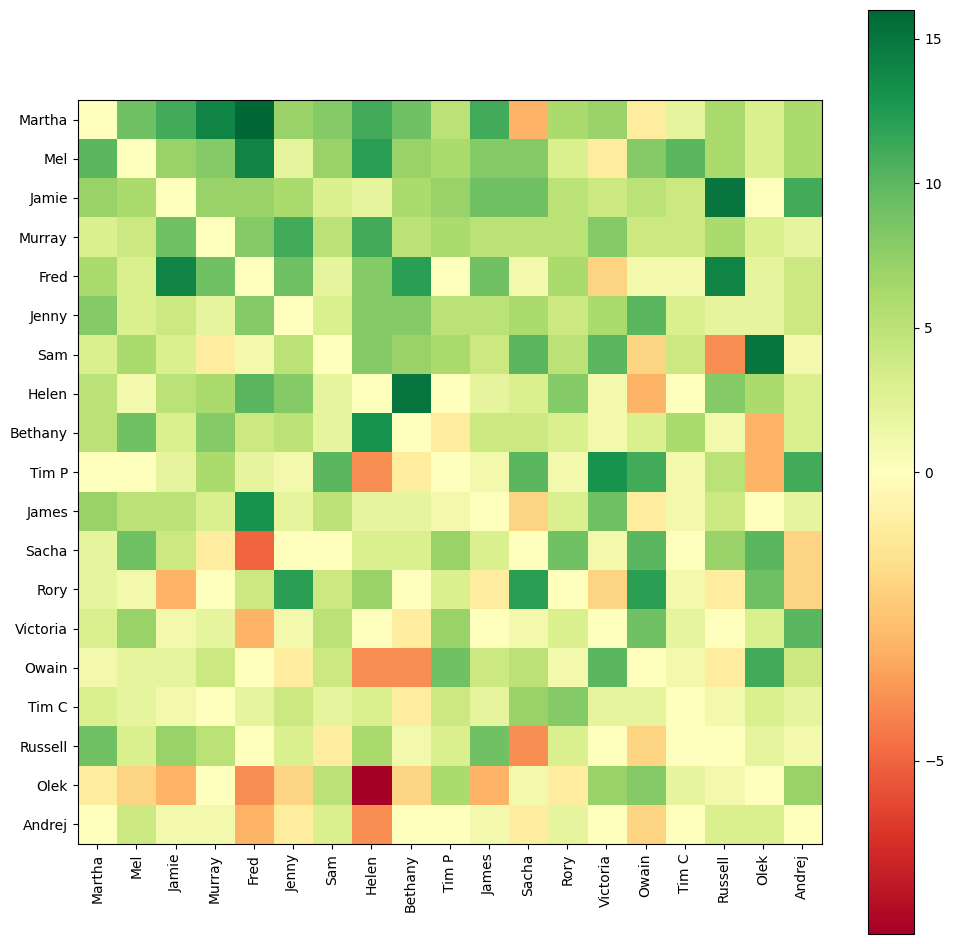

In [6]:
fig, ax = plt.subplots(figsize=(12,12))

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)
norm = TwoSlopeNorm(vmin=np.min(correlation),
                        vcenter=0,
                        vmax=np.max(correlation))

plt.imshow(correlation, cmap='RdYlGn', norm=norm, interpolation='nearest')
plt.xticks(np.arange(len(winning_order)), winning_order, rotation='vertical')
plt.yticks(np.arange(len(winning_order)), winning_order)


cbar = plt.colorbar()

plt.show()

In [27]:
biggest_stans = np.unravel_index(np.argsort(-correlation.reshape(-1))[:10], correlation.shape)
for row, col in zip(*biggest_stans):
    print(f"{winning_order[col]} for {winning_order[row]}: {int(correlation[row, col])}")


Fred for Martha: 16
Bethany for Helen: 15
Russell for Jamie: 15
Olek for Sam: 15
Jamie for Fred: 14
Russell for Fred: 14
Fred for Mel: 14
Murray for Martha: 14
Victoria for Tim P: 13
Fred for James: 13


In [28]:
biggest_haters = np.unravel_index(np.argsort(correlation.reshape(-1))[:10], correlation.shape)
for row, col in zip(*biggest_haters):
    print(f"{winning_order[col]} for {winning_order[row]}: {int(correlation[row, col])}")


Helen for Olek: -8
Fred for Sacha: -5
Russell for Sam: -4
Fred for Olek: -4
Sacha for Russell: -4
Bethany for Owain: -4
Helen for Andrej: -4
Helen for Tim P: -4
Helen for Owain: -4
Fred for Victoria: -3


In [26]:
df["round_score"] = df[winning_order].sum(axis=1)

# Round winners

for round_name, (round, scores) in zip(round_names, df.groupby("round")):
    winning_score = scores["round_score"].max()
    a = f"Round {round} | {round_name}"
    print(a + "\n" + '-'*len(a))
    for _, row in scores[scores["round_score"] == winning_score][["submitter", "track_name", "round_score"]].iterrows():
        print(f"{row['submitter']:10} | {row['track_name']:40} | {int(row['round_score'])}")


Round 1 | generation game
-------------------------
Sacha      | Message In A Bottle                      | 16
Bethany    | Gypsy Woman (La Da Dee La Da Da)         | 16
Round 2 | remix
---------------
Murray     | 19-2000 - Soulchild Remix                | 19
Martha     | Flowers - Sunship Remix                  | 19
Round 3 | songs to code to
--------------------------
Jenny      | Song of Storms                           | 18
Round 4 | ich spreche kein englisch
-----------------------------------
Murray     | Mundian to Bach Ke                       | 29
Round 5 | wish you were here
----------------------------
Mel        | London Calling - Remastered              | 19
Round 6 | film soundtrack
-------------------------
Jamie      | Lose Yourself                            | 23
Round 7 | yesteryear
--------------------
Jamie      | Nothing Matters                          | 15
Round 8 | 120 seconds to go
---------------------------
Mel        | Fell In Love With a Girl              

In [10]:
df.sort_values("round_score", ascending=False).iloc[:10][["submitter", "track_name", "round_score"]]

,submitter,track_name,round_score
168,Murray,Mundian to Bach Ke,29.0
76,Jamie,Lose Yourself,23.0
57,Jamie,Hurt,23.0
38,Mel,Fell In Love With a Girl,21.0
77,Martha,9 to 5,21.0
0,Rory,SHUM,20.0
151,Martha,Flowers - Sunship Remix,19.0
131,Mel,London Calling - Remastered,19.0
150,Murray,19-2000 - Soulchild Remix,19.0
113,Jenny,Song of Storms,18.0


In [11]:
df.sort_values("round_score", ascending=True).iloc[:10][["submitter", "track_name", "round_score"]]

,submitter,track_name,round_score
56,Andrej,Baby Shark,-17.0
93,Olek,Waters of Nazareth x We Are your Friends x Pha...,-13.0
75,James,Bohemian Rhapsody,-11.0
18,Russell,Congratulations,-10.0
186,Andrej,Dragostea Din Tei,-10.0
74,Sacha,Painkiller,-7.0
148,Bethany,Atlantic City,-5.0
185,Tim P,Tequila,-5.0
130,Olek,Final - Live Version - Rappel,-5.0
92,Andrej,"Come What May - From ""Moulin Rouge"" Soundtrack",-5.0


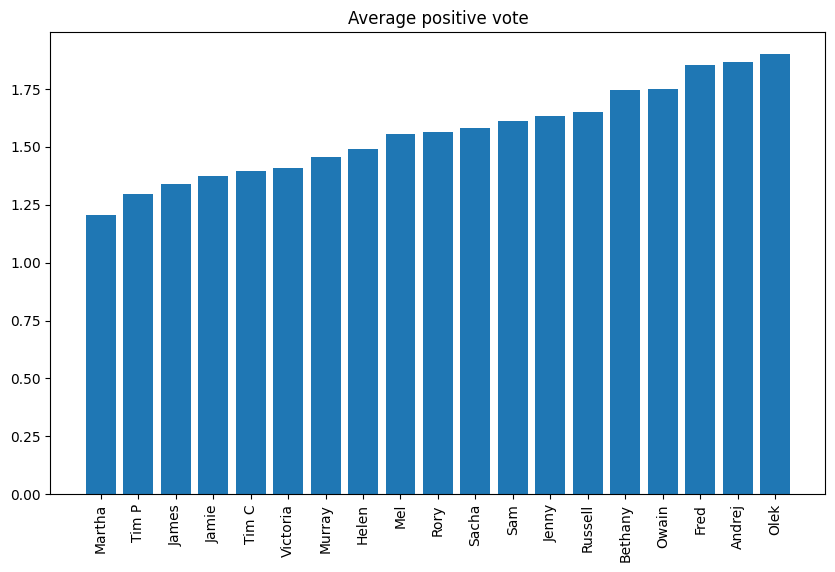

In [12]:
x = arr.reshape(-1, len(winning_order))
x[x <= 0.0] = np.nan
a = np.nanmean(x, axis=0)

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Average positive vote")

ax.bar(np.arange(len(winning_order)), a[np.argsort(a)])
ax.set_xticks(np.arange(len(winning_order)), labels=[winning_order[i] for i in np.argsort(a)], rotation="vertical")

plt.show()

In [13]:
df["song_age_seconds"] = (datetime.now() - df["date"]).dt.total_seconds()

In [14]:
# Average song age

df.groupby("submitter")["song_age_seconds"].mean().sort_values().map(lambda x: datetime.now() - timedelta(seconds=x))

submitter
Victoria   2017-06-01 12:00:00.014943
Rory       2016-05-26 07:12:00.014954
Owain      2015-03-18 14:24:00.014955
Olek       2013-07-03 00:00:00.014956
Sam        2012-07-15 04:48:00.014957
Murray     2012-03-01 07:12:00.014958
Andrej     2010-06-12 00:00:00.014959
Tim P      2007-01-22 12:00:00.014960
Jenny      2006-05-20 00:00:00.014961
Helen      2006-05-14 16:48:00.014962
Bethany    2006-04-13 16:00:00.014963
Tim C      2005-04-27 15:00:00.014964
Mel        2004-10-30 09:36:00.014965
Sacha      2002-02-24 16:48:00.014966
Martha     2001-09-21 16:48:00.014967
Jamie      2001-07-10 07:12:00.014968
Russell    2000-02-20 07:12:00.014970
James      1998-11-06 14:24:00.014971
Fred       1993-08-02 02:24:00.014972
Name: song_age_seconds, dtype: datetime64[ns]

In [15]:
# song length

df[df["round"] != 8].groupby("submitter")["duration"].sum()

submitter
Andrej      1848.219
Bethany     1723.012
Fred        2146.785
Helen       2266.625
James       2915.843
Jamie       2389.655
Jenny       1890.889
Martha      2137.663
Mel         1868.776
Murray      2037.116
Olek        2260.932
Owain       1887.041
Rory        2030.768
Russell     2825.664
Sacha       2442.544
Sam         1832.054
Tim C       1694.391
Tim P       1813.080
Victoria    1775.183
Name: duration, dtype: float64

In [16]:
df.sort_values("duration", ascending=False)[["submitter", "track_name", "duration"]].iloc[:10]

,submitter,track_name,duration
125,Russell,Blue Room,1053.813
127,James,Never Gonna Reach Me - Hot Toddy Remix,580.363
118,Sacha,Exercises in Futility V,495.626
160,Jamie,"Girls & Boys - Pet Shop Boys Remix, 2012 Remaster",436.546
37,Tim C,Seek & Destroy - Remastered,414.720
157,James,"Relight My Fire - 12"" Disco Remix",406.213
93,Olek,Waters of Nazareth x We Are your Friends x Pha...,391.782
154,Helen,Heads Will Roll - A-Trak Remix,383.893
65,Murray,War Pigs,379.647
100,James,Satisfy My Soul,362.956


In [17]:
df[df["round"]!=8].sort_values("duration")[["submitter", "track_name", "duration"]].iloc[:10]

,submitter,track_name,duration
129,Victoria,Baby Park,55.500
15,Sam,Bono's a Fucking Cunt,95.506
182,Sacha,Policia - 2017 Remaster,106.866
95,Bethany,Speed Drive (From Barbie The Album),117.809
178,Bethany,Laisse Tomber Les Filles,125.933
124,Sam,Screaming Man - Sound Effect,133.355
185,Tim P,Tequila,135.240
183,Tim C,Die Eier von Satan,137.360
96,Andrej,My Love Mine All Mine,137.773
87,Owain,"Comptine d'un autre été, l'après-midi",140.733


In [18]:
# Energy

df.groupby("submitter")["energy"].mean().sort_values(ascending=False)

submitter
Sacha       0.893900
Rory        0.863600
Murray      0.788190
Mel         0.768800
Sam         0.767300
Tim C       0.765429
Jenny       0.758900
Helen       0.748000
Tim P       0.738600
Bethany     0.736333
Owain       0.732200
Russell     0.719800
Jamie       0.692300
Victoria    0.692000
James       0.661500
Olek        0.656600
Fred        0.626700
Martha      0.619100
Andrej      0.509002
Name: energy, dtype: float64

In [19]:
df.sort_values("energy", ascending=False)[["submitter", "track_name", "energy"]].iloc[:10]

,submitter,track_name,energy
130,Olek,Final - Live Version - Rappel,0.996
74,Sacha,Painkiller,0.995
31,Rory,(sic),0.994
182,Sacha,Policia - 2017 Remaster,0.991
42,Sam,Freaks to the Front,0.988
129,Victoria,Baby Park,0.982
38,Mel,Fell In Love With a Girl,0.982
159,Sacha,Jesus Built My Hotrod (Powerman 5000 Remix),0.979
36,Owain,輪舞-revolution,0.975
118,Sacha,Exercises in Futility V,0.971


In [20]:
df.sort_values("energy")[["submitter", "track_name", "energy"]].iloc[:10]

,submitter,track_name,energy
126,Andrej,4'33'',0.00002
85,Murray,Concerning Hobbits,0.06290
71,Olek,Creep,0.10800
39,Jamie,Golden Slumbers - Remastered 2009,0.15200
124,Sam,Screaming Man - Sound Effect,0.18200
87,Owain,"Comptine d'un autre été, l'après-midi",0.19200
117,Tim P,Vision On,0.19400
52,Fred,Cripple Creek Ferry,0.22200
24,Andrej,Dub Be Good To Me,0.27200
58,Bethany,Killing Me Softly With His Song,0.28900


In [21]:
df.sort_values("danceability", ascending=False)[["submitter", "track_name", "danceability"]].iloc[:10]

,submitter,track_name,danceability
121,Martha,Computer World - 2009 Remaster,0.931
51,Helen,BIZCOCHITO,0.930
28,Mel,Family Affair,0.911
41,Jenny,Old Town Road,0.907
32,Murray,Me Myself and I,0.889
2,Martha,Think About Things,0.872
24,Andrej,Dub Be Good To Me,0.861
30,Helen,Can I Kick It?,0.848
50,Olek,Fly Away,0.846
56,Andrej,Baby Shark,0.829


In [22]:
df.sort_values("danceability")[["submitter", "track_name", "danceability"]].iloc[:10]

,submitter,track_name,danceability
126,Andrej,4'33'',0.173
149,Tim C,Munich,0.184
35,Russell,New Rose,0.191
118,Sacha,Exercises in Futility V,0.194
71,Olek,Creep,0.200
136,Martha,By The Time I Get To Phoenix - Remastered 2001,0.218
146,Jamie,Trains To Brazil,0.256
65,Murray,War Pigs,0.275
92,Andrej,"Come What May - From ""Moulin Rouge"" Soundtrack",0.288
15,Sam,Bono's a Fucking Cunt,0.304


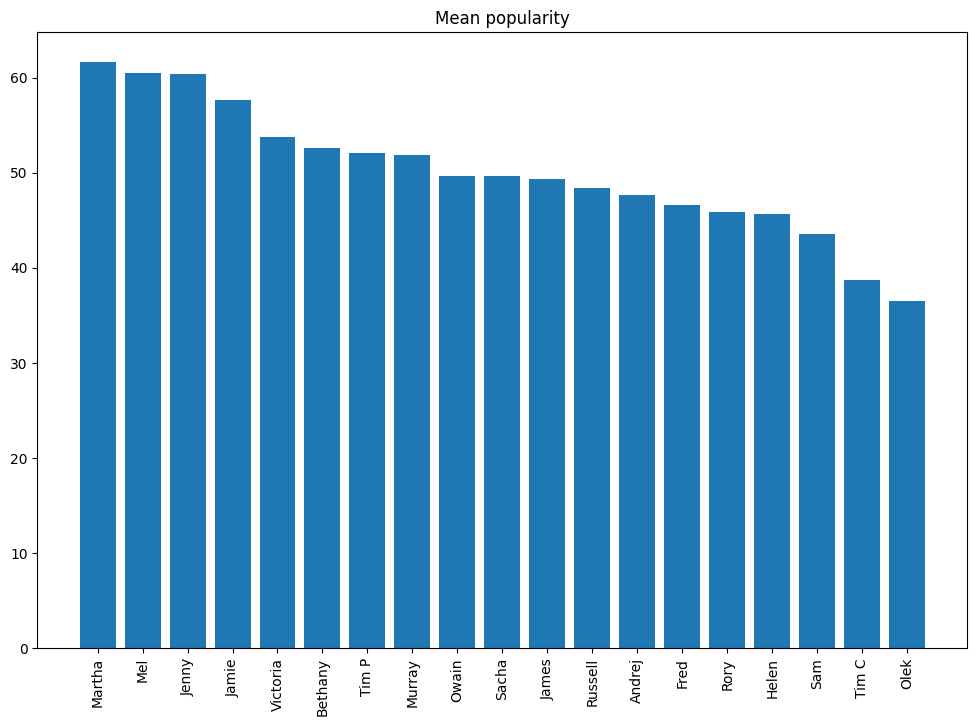

In [23]:
# popularity

fig, ax = plt.subplots(figsize=(12, 8))

pop = df.groupby("submitter")["popularity"].mean().sort_values(ascending=False)
ax.bar(range(len(pop)), pop)
ax.set_xticks(range(len(pop)), pop.index, rotation="vertical")


ax.set_title("Mean popularity")

plt.show()

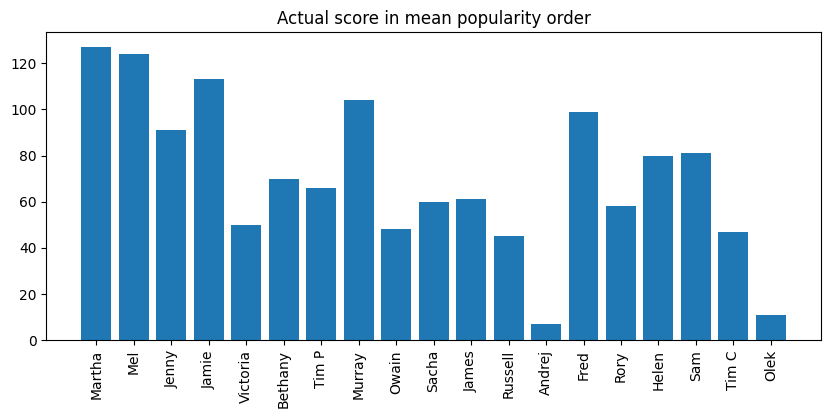

In [30]:
actual = df.groupby("submitter")[winning_order].sum().sum(axis=1).reindex(pop.index)

fig, ax = plt.subplots(figsize=(10, 4))

ax.bar(range(len(pop)), actual)
ax.set_xticks(range(len(pop)), pop.index, rotation="vertical")


ax.set_title("Actual score in mean popularity order")

plt.show()

In [42]:
from operator import add
from functools import reduce
from collections import defaultdict

def find_most_frequent_genre(genres: list[str]) -> str:
    counter = defaultdict(int)
    for genre in genres:
        counter[genre] += 1
    genres, counts = list(zip(*counter.items()))
    counts = np.array(counts)
    return genres[np.argmax(counts)]
    
df.groupby("submitter")["genres"].apply(lambda x: reduce(add, x)).map(find_most_frequent_genre)

submitter
Andrej        hollywood
Bethany         hip hop
Fred            britpop
Helen       electronica
James           hip hop
Jamie              rock
Jenny         dance pop
Martha         neo soul
Mel                rock
Murray          hip hop
Olek          lo-fi rap
Owain             j-pop
Rory           nu metal
Russell      indie rock
Sacha              rock
Sam              ambeat
Tim C              rock
Tim P         dance pop
Victoria      dark rock
Name: genres, dtype: object

In [44]:
df.groupby("submitter")["genres"].apply(lambda x: reduce(add, x)).map(lambda x: len(set(x))).sort_values(ascending=False)

submitter
Russell     65
Murray      46
Helen       43
Sacha       43
Fred        35
James       35
Martha      35
Tim P       34
Mel         32
Bethany     31
Jamie       30
Jenny       26
Sam         24
Tim C       24
Olek        23
Andrej      22
Victoria    21
Rory        17
Owain       11
Name: genres, dtype: int64

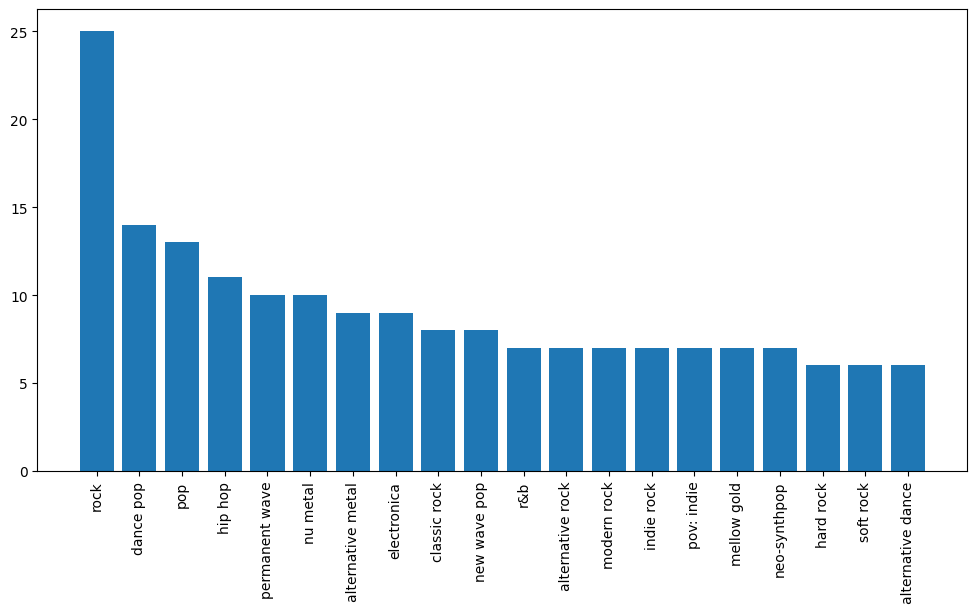

In [174]:
counter = defaultdict(int)
for genre in reduce(add, df["genres"]):
    counter[genre] += 1

genres, counts = list(zip(*sorted(list(counter.items()), key=lambda x: x[1], reverse=True)))

fig, ax = plt.subplots(figsize=(12,6))

ax.bar(range(20), counts[:20])
ax.set_xticks(range(20), genres[:20], rotation="vertical")

plt.show()



In [186]:
# calculate unique genres

submitter_genres = {submitter: set(reduce(add, genres)) for submitter, genres in df.groupby("submitter")["genres"]}

for submitter in list(submitter_genres):
    submitted = submitter_genres.pop(submitter)
    rest = reduce(lambda a, b: a.union(b), submitter_genres.values())
    difference = submitted.difference(rest)
    if len(difference):
        print(f"{submitter} was the only one to submit: {difference}")
    else:
        print(f"{submitter} submitted no unique genres")
    submitter_genres[submitter] = submitted

Andrej was the only one to submit: {'experimental', 'avant-garde', 'brooklyn indie', 'romanian pop', 'york indie', 'cartoon', 'hip house', "children's music", 'american contemporary classical', 'classical', 'contemporary classical', 'dong-yo'}
Bethany was the only one to submit: {'heartland rock', 'metropopolis', 'crossover thrash', 'ye ye', 'straight edge', 'shimmer pop', 'chillwave', 'greek pop', 'hardcore', 'candy pop', 'nyhc', 'diva house'}
Fred was the only one to submit: {'neue deutsche welle', 'roots rock', 'classic canadian rock', 'classic russian pop', 'reggae', 'jump up', 'ska', 'bass house', 'old school bassline', 'canadian singer-songwriter', 'ukrainian pop', 'lovers rock', 'roots reggae'}
Helen was the only one to submit: {'welsh indie', 'queens hip hop', 'wonky', 'electronic trap', 'folk', 'electro house', 'solo wave', 'turntablism', 'swedish electropop', 'r&b en espanol', 'fidget house', 'canadian electronic', 'swedish synth', 'cardiff indie', 'chamber psych', 'swedish s

In [152]:
def correlate_voters(votes):
    # Ensure that votes is a 3D array
    assert votes.ndim == 3, "Input array must be 3D"
    
    num_rounds, num_participants, _ = votes.shape
    
    # Reshape the array to (num_rounds * num_participants, num_participants)
    reshaped_votes = votes.reshape(num_rounds * num_participants, num_participants)
    
    # Transpose to get (num_participants, num_rounds * num_participants)
    transposed_votes = reshaped_votes.T
    
    # Compute the correlation matrix of the votes given by each participant
    correlation_matrix = np.corrcoef(transposed_votes)
    
    return correlation_matrix

voting_correlation = correlate_voters(arr)

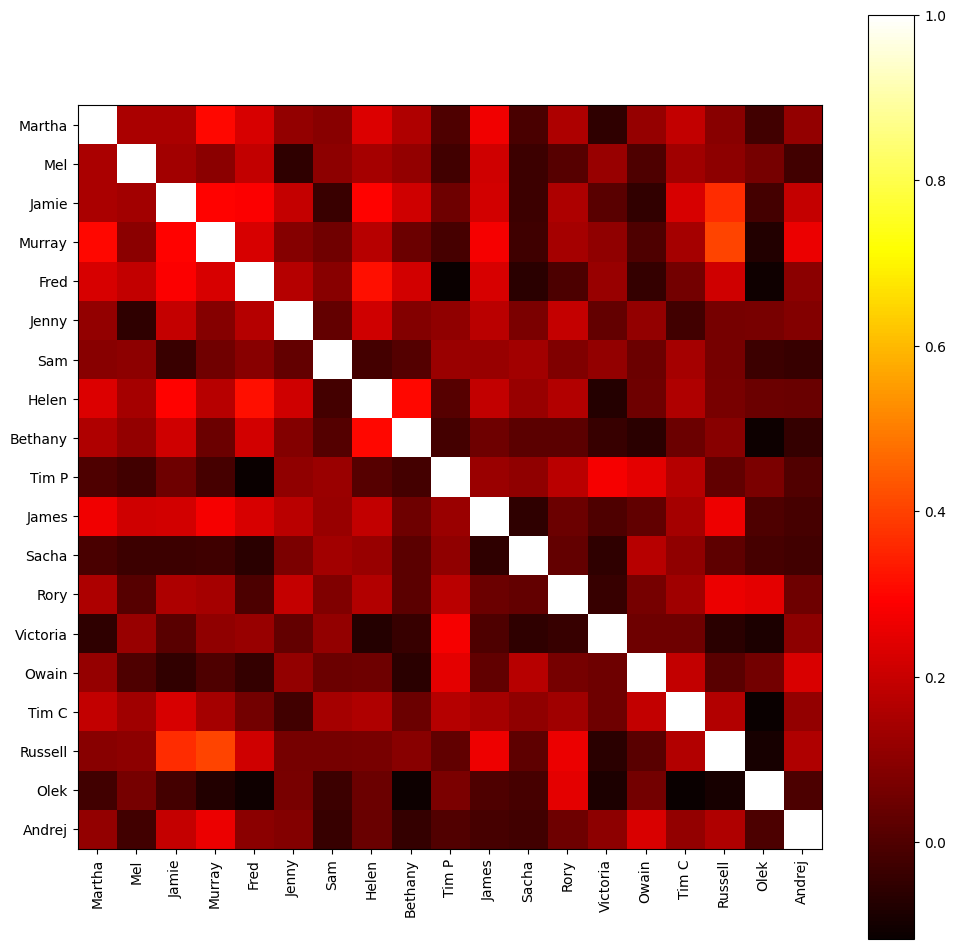

In [153]:
fig, ax = plt.subplots(figsize=(12,12))

im = ax.imshow(voting_correlation, cmap='hot', interpolation='nearest')
ax.set_xticks(np.arange(len(winning_order)), winning_order, rotation="vertical")
ax.set_yticks(np.arange(len(winning_order)), winning_order)

plt.colorbar(im)
plt.show()

In [157]:
for i, j in enumerate(np.argsort(voting_correlation, axis=1)[:,-2]): # ignore self correlation
    print(f"{winning_order[i]} most correlated with {winning_order[j]}: {voting_correlation[i][j]:.3f}")

Martha most correlated with Murray: 0.304
Mel most correlated with James: 0.211
Jamie most correlated with Russell: 0.363
Murray most correlated with Russell: 0.405
Fred most correlated with Helen: 0.318
Jenny most correlated with Helen: 0.212
Sam most correlated with Tim C: 0.143
Helen most correlated with Fred: 0.318
Bethany most correlated with Helen: 0.304
Tim P most correlated with Victoria: 0.278
James most correlated with Murray: 0.277
Sacha most correlated with Owain: 0.173
Rory most correlated with Russell: 0.259
Victoria most correlated with Tim P: 0.278
Owain most correlated with Tim P: 0.249
Tim C most correlated with Jamie: 0.225
Russell most correlated with Murray: 0.405
Olek most correlated with Rory: 0.249
Andrej most correlated with Murray: 0.262


In [159]:
for i, j in enumerate(np.argmin(voting_correlation, axis=1)):
    print(f"{winning_order[i]} least correlated with {winning_order[j]}: {voting_correlation[i][j]:.3f}")

Martha least correlated with Victoria: -0.054
Mel least correlated with Jenny: -0.055
Jamie least correlated with Owain: -0.048
Murray least correlated with Olek: -0.078
Fred least correlated with Tim P: -0.117
Jenny least correlated with Mel: -0.055
Sam least correlated with Andrej: -0.043
Helen least correlated with Victoria: -0.069
Bethany least correlated with Olek: -0.109
Tim P least correlated with Fred: -0.117
James least correlated with Sacha: -0.053
Sacha least correlated with Fred: -0.062
Rory least correlated with Victoria: -0.042
Victoria least correlated with Olek: -0.086
Owain least correlated with Bethany: -0.062
Tim C least correlated with Olek: -0.116
Russell least correlated with Olek: -0.093
Olek least correlated with Tim C: -0.116
Andrej least correlated with Bethany: -0.047


In [131]:
np.min(x)

-0.117182947134728

In [140]:
def compute_round_results(votes):
    # Sum votes received in each round for each participant
    round_results = np.sum(votes, axis=2)  # Shape: (num_rounds, num_participants)
    return round_results

def correlate_votes_given_with_results(votes):
    # Ensure that votes is a 3D array
    assert votes.ndim == 3, "Input array must be 3D"
    
    num_rounds, num_participants, _ = votes.shape
    
    # Compute round results
    round_results = compute_round_results(votes)  # Shape: (num_rounds, num_participants)
    
    # Reshape the array to get votes given by each participant over all rounds
    reshaped_votes = votes.reshape(num_rounds * num_participants, num_participants)
    
    # Transpose to get (num_participants, num_rounds * num_participants)
    transposed_votes = reshaped_votes.T
    
    # Reshape round results to match (num_rounds * num_participants)
    flattened_results = round_results.flatten()  # Shape: (num_rounds * num_participants,)
    
    # Compute correlation between each participant's votes given and the round results
    correlations = np.corrcoef(transposed_votes, flattened_results, rowvar=True)
    
    # Extract the relevant part of the correlation matrix (excluding self-correlation of results)
    correlation_with_results = correlations[:-1, -1]
    
    return correlation_with_results
result_correlation = correlate_votes_given_with_results(arr)

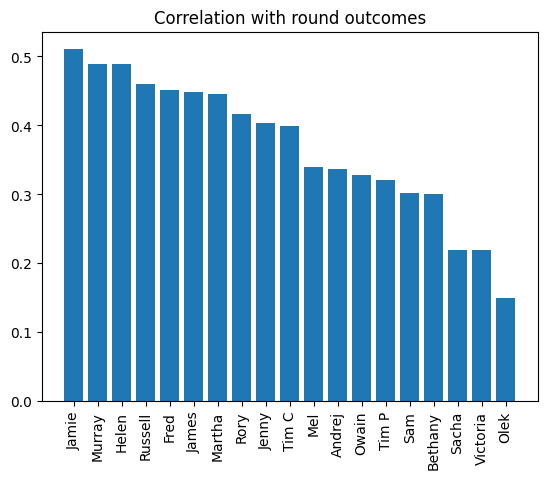

In [146]:
plt.bar(np.arange(len(winning_order)), result_correlation[np.argsort(result_correlation)[::-1]])
plt.xticks(np.arange(len(winning_order)), [winning_order[i] for i in np.argsort(result_correlation)[::-1]], rotation="vertical")

plt.title("Correlation with round outcomes")

plt.show()